### Import libraries

In [1]:
import requests, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Set variables

In [2]:
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=AUD&limit=2000')

### Import data

In [3]:
bitcoin = pd.DataFrame(json.loads(res.content)['Data'])
bitcoin["Date"] = pd.to_datetime(bitcoin["time"], unit='s')
bitcoin = bitcoin[["Date","time","open","high","low","close","volumefrom","volumeto"]]
bitcoin = bitcoin.sort_values(by=["Date"], ascending=[True])

In [4]:
bitcoin[1:10]

,Date,time,open,high,low,close,volumefrom,volumeto
1,2013-03-23,1363996800,78.75,85.15,67.27,72.20,23.92,1775.48
2,2013-03-24,1364083200,67.55,84.97,53.84,53.84,46.60,3477.25
3,2013-03-25,1364169600,77.74,86.91,66.61,81.70,130.90,9732.42
4,2013-03-26,1364256000,75.21,88.51,50.97,69.69,80.00,6066.91
5,2013-03-27,1364342400,53.84,94.52,53.84,79.42,179.08,14971.20
6,2013-03-28,1364428800,93.39,117.80,69.67,69.67,60.03,5430.70
7,2013-03-29,1364515200,93.54,100.11,92.69,100.11,2.54,242.99
8,2013-03-30,1364601600,101.05,102.95,96.64,100.25,16.75,1678.68
9,2013-03-31,1364688000,100.25,118.30,69.67,99.99,8.80,837.63


### Convert data to relevant format

In [5]:
bitcoin_array = pd.DataFrame(bitcoin["close"]).values
bitcoin_array = bitcoin_array.astype("float64")
bitcoin_array.shape

(2001, 1)

### Normalise bitcoin data

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_array = scaler.fit_transform(bitcoin_array)
bitcoin_array[1:10]

array([[0.0006864 ],
       [0.        ],
       [0.00104156],
       [0.00059256],
       [0.00095632],
       [0.00059181],
       [0.00172983],
       [0.00173506],
       [0.00172534]])

### Create train and test set

Note we use last 7 days for test dataset and prior 180 days for training dataset.

In [7]:
test_threshold = 7
max_threshold = 180
train = bitcoin_array[(len(bitcoin_array)-max_threshold-test_threshold):(len(bitcoin_array)-test_threshold)]
test = bitcoin_array[(len(bitcoin_array)-test_threshold):]

### Create window function

Function creates arrays which look at previous `x` values.

Note window can be updated.

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Build LSTM model

In [11]:
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
 - 1s - loss: 0.0336
Epoch 2/30
 - 0s - loss: 0.0012
Epoch 3/30
 - 1s - loss: 9.5564e-04
Epoch 4/30
 - 1s - loss: 9.2006e-04
Epoch 5/30
 - 1s - loss: 8.8619e-04
Epoch 6/30
 - 0s - loss: 8.7431e-04
Epoch 7/30
 - 0s - loss: 8.3472e-04
Epoch 8/30
 - 0s - loss: 8.0126e-04
Epoch 9/30
 - 0s - loss: 7.5677e-04
Epoch 10/30
 - 0s - loss: 7.2069e-04
Epoch 11/30
 - 0s - loss: 6.9626e-04
Epoch 12/30
 - 0s - loss: 6.5956e-04
Epoch 13/30
 - 0s - loss: 6.1563e-04
Epoch 14/30
 - 0s - loss: 5.8598e-04
Epoch 15/30
 - 0s - loss: 5.2657e-04
Epoch 16/30
 - 1s - loss: 5.2981e-04
Epoch 17/30
 - 1s - loss: 4.6634e-04
Epoch 18/30
 - 1s - loss: 4.3925e-04
Epoch 19/30
 - 0s - loss: 4.1270e-04
Epoch 20/30
 - 0s - loss: 3.8090e-04
Epoch 21/30
 - 0s - loss: 3.6085e-04
Epoch 22/30
 - 0s - loss: 3.3542e-04
Epoch 23/30
 - 0s - loss: 3.1564e-04
Epoch 24/30
 - 0s - loss: 2.9584e-04
Epoch 25/30
 - 0s - loss: 2.8535e-04
Epoch 26/30
 - 0s - loss: 2.6906e-04
Epoch 27/30
 - 0s - loss: 2.5722e-04
Epoch 28/30
 - 0s 

In [12]:
# Make predictions.
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

# Invert predictions, transform back to equivalent bitcoin prices.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error.
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 408.17 RMSE
Test Score: 527.92 RMSE


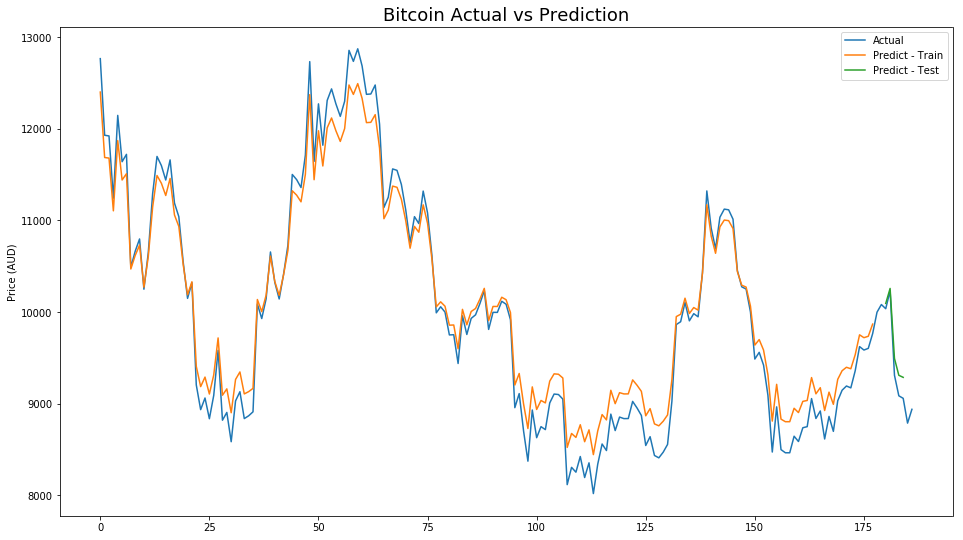

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(bitcoin_array)
trainPredictPlot[:, :] = np.nan
for i in range(0, len(trainPredict), 1):
    trainPredictPlot[(len(bitcoin_array)-max_threshold-test_threshold)+i] = trainPredict[i]
testPredictPlot = np.empty_like(bitcoin_array)
testPredictPlot[:, :] = np.nan
for i in range(0, len(testPredict), 1):
    testPredictPlot[(len(bitcoin_array)-test_threshold)+i] = testPredict[i]

# Revert back to relevant periods
bitcoin_array_plot = bitcoin_array[(len(bitcoin_array)-max_threshold-test_threshold):len(bitcoin_array)]
trainPredictPlot = trainPredictPlot[(len(trainPredictPlot)-max_threshold-test_threshold):]
testPredictPlot = testPredictPlot[(len(testPredictPlot)-max_threshold-test_threshold):]
plt.subplots(figsize=(16,9))
plt.plot(scaler.inverse_transform(bitcoin_array_plot), label="Actual")
plt.plot(trainPredictPlot, label="Predict - Train")
plt.plot(testPredictPlot, label="Predict - Test")
plt.title("Bitcoin Actual vs Prediction", fontsize=18); plt.xlabel(""); plt.ylabel("Price (AUD)")
plt.legend(loc="upper right")
plt.show()

We observe that **LSTM** follows the overall pattern of bitcoin prices quite well, albeit our root mean square error appears high. However as there is high volatility with large fluctuations in price, we can assume the model predicts quite well for future bitcoin prices.

Model can be improved by changing the following parameters:

* Update window function.
* Increasing number of epochs.
* Changing hidden layer structure.

#### LSTM model with window size 5

Test model above with window of size 5.

In [14]:
# Define window.
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Train model with new window.
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
 - 2s - loss: 0.0207
Epoch 2/30
 - 1s - loss: 0.0014
Epoch 3/30
 - 1s - loss: 0.0013
Epoch 4/30
 - 1s - loss: 0.0012
Epoch 5/30
 - 1s - loss: 0.0011
Epoch 6/30
 - 1s - loss: 9.6201e-04
Epoch 7/30
 - 1s - loss: 9.0731e-04
Epoch 8/30
 - 1s - loss: 7.8407e-04
Epoch 9/30
 - 1s - loss: 7.2075e-04
Epoch 10/30
 - 1s - loss: 6.4154e-04
Epoch 11/30
 - 1s - loss: 5.8094e-04
Epoch 12/30
 - 1s - loss: 5.4374e-04
Epoch 13/30
 - 1s - loss: 5.1263e-04
Epoch 14/30
 - 1s - loss: 4.8451e-04
Epoch 15/30
 - 1s - loss: 4.7302e-04
Epoch 16/30
 - 1s - loss: 4.5673e-04
Epoch 17/30
 - 1s - loss: 4.3438e-04
Epoch 18/30
 - 1s - loss: 4.7486e-04
Epoch 19/30
 - 1s - loss: 4.3953e-04
Epoch 20/30
 - 1s - loss: 4.4532e-04
Epoch 21/30
 - 1s - loss: 4.5141e-04
Epoch 22/30
 - 1s - loss: 4.6094e-04
Epoch 23/30
 - 1s - loss: 4.2232e-04
Epoch 24/30
 - 1s - loss: 4.2173e-04
Epoch 25/30
 - 1s - loss: 4.1895e-04
Epoch 26/30
 - 1s - loss: 4.2210e-04
Epoch 27/30
 - 1s - loss: 3.9968e-04
Epoch 28/30
 - 1s - loss: 4.37

In [15]:
# Make predictions.
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

# Invert predictions, transform back to equivalent bitcoin prices.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error.
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 511.93 RMSE
Test Score: 798.07 RMSE


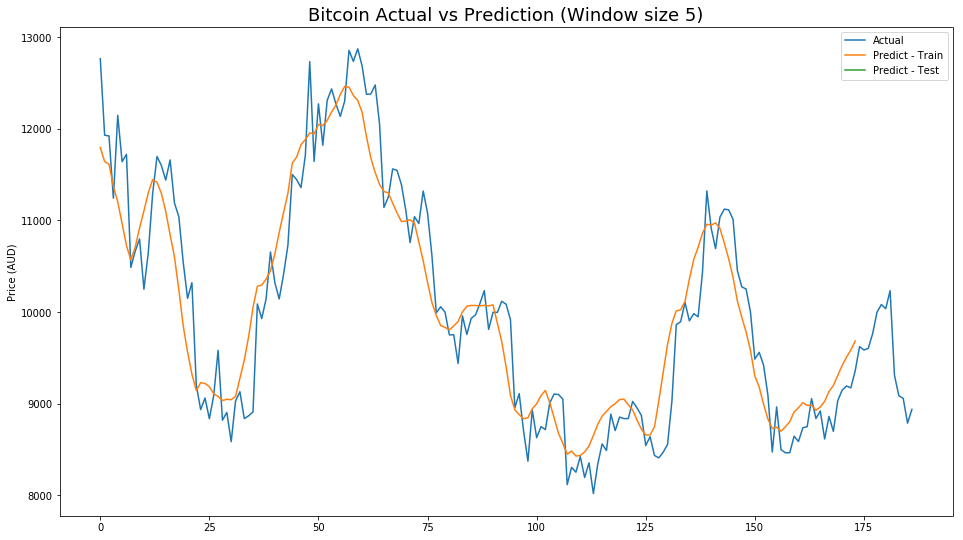

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(bitcoin_array)
trainPredictPlot[:, :] = np.nan
for i in range(0, len(trainPredict), 1):
    trainPredictPlot[(len(bitcoin_array)-max_threshold-test_threshold)+i] = trainPredict[i]
testPredictPlot = np.empty_like(bitcoin_array)
testPredictPlot[:, :] = np.nan
for i in range(0, len(testPredict), 1):
    testPredictPlot[(len(bitcoin_array)-test_threshold)+i] = testPredict[i]

# Revert back to relevant periods
bitcoin_array_plot = bitcoin_array[(len(bitcoin_array)-max_threshold-test_threshold):len(bitcoin_array)]
trainPredictPlot = trainPredictPlot[(len(trainPredictPlot)-max_threshold-test_threshold):]
testPredictPlot = testPredictPlot[(len(testPredictPlot)-max_threshold-test_threshold):]
plt.subplots(figsize=(16,9))
plt.plot(scaler.inverse_transform(bitcoin_array_plot), label="Actual")
plt.plot(trainPredictPlot, label="Predict - Train")
plt.plot(testPredictPlot, label="Predict - Test")
plt.title("Bitcoin Actual vs Prediction (Window size 5)", fontsize=18); plt.xlabel(""); plt.ylabel("Price (AUD)")
plt.legend(loc="upper right")
plt.show()

We observe that increasing the window creates a smoother function and is more realistic for understanding the overall volatility trends.

Note that the root mean square error is **higher** with larger window compared to a lower window.